# 強化学習 3日目 @ Summer School 数理物理 2021
## OpenAIGymを使ってみる
- 初歩的なタスク CartPole を使用。
- 状態空間は連続、行動数は2。
- 状態を離散化し、テーブル形式のQ学習を適用。
***
Tetsuro Morimura, 2021

# 準備

### モジュールのインポート

In [ ]:
# essential models
import gym
import numpy as np
from matplotlib import pyplot as plt

# modules for movie
from IPython import display as ipythondisplay
import glob
import io
import base64
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display
import os

# 環境の設定

### ゲーム環境の設定

In [ ]:
env = gym.make('CartPole-v0') ## ゲーム環境の設定（棒制御）

### 動画の記録、再生のための設定

- 動画関連のメソッドの定義

In [ ]:
def wrap_env(env):
    # force=True：以前のモニタファイルを自動的にクリア
    env = gym.wrappers.Monitor(env, './video', force=True)
    return env

def show_video():
    mp4list = glob.glob('video/*.mp4')
    #print(len(mp4list))
    if len(mp4list) > 0:
        for m in range(len(mp4list)):
            mp4 = mp4list[m]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(ipythondisplay.HTML(data='''
                <video alt="test" autoplay loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
          print("Could not find video")

- ディスプレイの設定

In [ ]:
display = Display(visible=0, size=(1024, 768))
display.start()

#os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

### 動作確認

- 観測空間，行動空間の確認

In [ ]:
print('observation space:', env.observation_space) ## 観測空間のチェック
print('action space:', env.action_space) ## 行動空間のチェック

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


- 環境を初期化して、初期観測を確認

In [ ]:
obs = env.reset() ## 環境の初期化
#env.render() ## 学習過程のレンダリング関数
print('initial observation:', obs)

initial observation: [ 0.00483539  0.0236957   0.01056274 -0.03297738]


- エピソード生成（行動は乱択）

In [ ]:
obs = env.reset() 

done = False
t    = 0
while not done:
  action = env.action_space.sample()    # ランダムな行動選択
  obs, r, done, info = env.step(action) # 行動を環境に入力して、次状態などを受け取る
  ## 出力の確認
  print('----------- time step {} --------'.format(t))
  print('selected action:', action)
  print('next observation:', obs)
  print('reward:', r)
  print('done:', done)
  print('info:', info)
  t += 1

----------- time step 0 --------
selected action: 0
next observation: [-3.88744317e-02 -1.55769571e-01  2.47606854e-05  2.84294410e-01]
reward: 1.0
done: False
info: {}
----------- time step 1 --------
selected action: 1
next observation: [-0.04198982  0.03935203  0.00571065 -0.00838071]
reward: 1.0
done: False
info: {}
----------- time step 2 --------
selected action: 0
next observation: [-0.04120278 -0.15585135  0.00554303  0.28609851]
reward: 1.0
done: False
info: {}
----------- time step 3 --------
selected action: 1
next observation: [-0.04431981  0.03919111  0.011265   -0.00483104]
reward: 1.0
done: False
info: {}
----------- time step 4 --------
selected action: 1
next observation: [-0.04353599  0.23414971  0.01116838 -0.29393854]
reward: 1.0
done: False
info: {}
----------- time step 5 --------
selected action: 0
next observation: [-0.03885299  0.03887032  0.00528961  0.0022457 ]
reward: 1.0
done: False
info: {}
----------- time step 6 --------
selected action: 0
next observati

- エピソードを動画に記録し、再生する

In [ ]:
n_episode = 2 # 3以上に設定しても、なぜか2エピソードしか保存されず..

# エピソードを生成し、動画を保存
envw = wrap_env(gym.make('CartPole-v0'))

for i in range(n_episode):

    observation = envw.reset()
    done = False
    total_reward = 0

    while not done:
        envw.render()
        action = env.action_space.sample()     # ランダムな行動選択
        obs, r, done, info = envw.step(action) # 行動を環境に入力して、次状態などを受け取る
        total_reward += r

    print('test episode:', i+1, 'total reward:', total_reward)

envw.close()

# 動画の再生
show_video()

# Colab上から動画を削除
!rm video/openaigym.video.*

test episode: 1 total reward: 13.0
test episode: 2 total reward: 12.0


# エージェントの設定

### RLエージェントクラスの定義
- アブストラクトクラス

In [ ]:
## Abstract RL agent class 
class Agent():
    def __init__(self, state_space, action_space, gamma=0.9):
        self.state_space  = state_space
        self.action_space = action_space
        self.gamma        = gamma
        self.experiences  = []
        self.timestep     = 0
        self.episode      = 0

    def reset(self):
        # エージェントの初期化
        raise NotImplementedError("class is abstract.") 

    def end_episode(self):
        # エピソード終了時の処理
        raise NotImplementedError("class is abstract.") 

    def add_experience(self, state, action, reward, next_state):
        # 経験データの追加
        raise NotImplementedError("class is abstract.") 

    def policy(self, state):
        # 行動選択
        raise NotImplementedError("class is abstract.")

    def learning(self):
        # 学習
        raise NotImplementedError("class is abstract.")

### Q学習エージェントクラスの実装
- Agentクラスを継承
- Q関数: Table形式
- 方策: Epsilon-greedy

In [ ]:
## Q-learning agent (tabular version with epsilon-greedy policy)
class TabularQlearning(Agent):
    def __init__(self, state_space, action_space, gamma=0.9, epsilon=[100., 100.],alpha=[200., 200.]):
        super().__init__(state_space, action_space, gamma)
        self.nstate  = len(state_space) 
        self.naction = len(action_space)
        self.q_fun   = np.random.randn(self.nstate, self.naction) / 1000
        self.epsilon = epsilon # hyper-param for e-greedy
        self.alpha   = alpha   # hyper-hparam for learning rate

    def reset(self, q_bias=0.):
        self.timestep    = 0
        self.episode     = 0
        self.experiences = []
        self.q_fun       = np.random.randn(self.nstate, self.naction) / 1000 + q_bias

    def end_episode(self):
        self.timestep = 0
        self.episode += 1
        self.experiences = []

    def add_experience(self, experience):
        self.experiences = experience

    def policy(self, state): #Epsilon-Greedy Agent Policy
        # epsilonの設定
        if isinstance(self.epsilon, list) != True:
            epsilon = self.epsilon
        else:
            epsilon = self.epsilon[0] / (self.episode + self.epsilon[1])
        # 行動選択
        if epsilon <= np.random.uniform():
            action = np.argmax(self.q_fun[state])
        else:
            action = np.random.choice(self.naction)
        return action

    def learning_rate(self):
        if isinstance(self.alpha, list) != True:
            learning_rate = self.alpha
        else:
            learning_rate = self.alpha[0] / (self.episode + self.alpha[1])
        return learning_rate

    def learning(self):
        state, action, reward, next_state, done = self.experiences
        if not done: #エピソードが途中または、最終ステップに到達した場合
            td_error = reward + self.gamma * np.max(self.q_fun[next_state]) - self.q_fun[state][action]
        else: # エピソード異常終了時（途中で失敗）
            td_error = reward - self.q_fun[state][action]
          
        self.q_fun[state][action] += self.learning_rate() * td_error 

### 状態離散化クラスの実装
- envを使って、n_episode回シミュレーションして、CartPoleの観測の範囲を求める
- n_partitionで定めた分割数を用いて、観測を離散化
- （観測の次元は４なので）状態数は分割数の4乗
    - n_partition = 2　⇒　16
    - n_partition = 3　⇒　81
    - n_partition = 4　⇒　256
    - n_partition = 5　⇒　625
    - ...
    - n_partition = 10　⇒　10,000

In [ ]:
class ObservationDiscretizer:
    def __init__(self, env, n_partition=6 ,n_episode=3000, var_max=[]):
        obs   = env.reset() 
        self.n_var       = len(obs)
        self.n_partition = n_partition
        self.n_state     = self.n_partition ** self.n_var
        self.threshold   = [] 
        # var_max(obsの範囲)の探索
        if len(var_max) == 0:
            var_max = np.zeros(self.n_var)
            for e in range(n_episode):
                obs  = env.reset() 
                done = False
                while not done:
                    action = env.action_space.sample() # ランダムな行動選択
                    obs, _, done, _ = env.step(action) # 行動を環境に入力して、次状態などを受け取る
                    var_max = np.max([np.abs(obs), var_max], axis=0) 
            var_max = 1.1*var_max # for safety
        # 閾値の設定
        for v in range(self.n_var):
            self.threshold.append( np.linspace(-var_max[v],var_max[v],n_partition+1)[1:-1] )          
        self.var_max = var_max
        
    def get_state(self,obs):
        obs_idx = np.zeros(self.n_var) 
        for v in range(self.n_var):
            obs_idx[v] = np.digitize(obs[v], bins=self.threshold[v])

        state = sum([x * (self.n_partition**i) for i, x in enumerate(obs_idx)])
        return int(state)

- 動作確認

num state:   81
thresholds: 
 [[-0.393597    0.393597  ]
 [-0.9746055   0.9746055 ]
 [-0.09906311  0.09906311]
 [-1.20625102  1.20625102]]


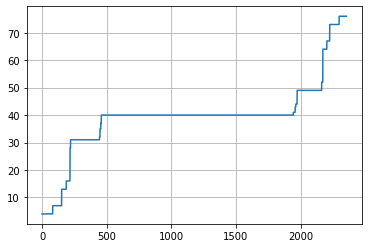

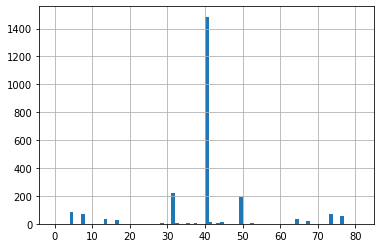

In [ ]:
obs_discretizer = ObservationDiscretizer(env, n_partition=3)
  
s_list = []
for e in range(100):
  t    = 0
  obs  = env.reset() 
  done = False
  while not done:
    action = env.action_space.sample() # ランダムな行動選択
    obs, _, done, _ = env.step(action) # 行動を環境に入力して、次状態などを受け取る
    s = obs_discretizer.get_state(obs)
    t+= 1
    s_list.append(s)


print('num state:  ',   obs_discretizer.n_state)
print('thresholds: \n', np.array(obs_discretizer.threshold))

plt.plot(np.sort(s_list))
plt.grid(which='both')
plt.show()

plt.hist(s_list, bins=obs_discretizer.n_state, range=(0,obs_discretizer.n_state))
plt.grid(which='both')
plt.show()

# 実験

### 実験条件の設定

In [ ]:
## Set parameters

# param for experiment
max_episode = 5000                        # num of experiments
n_timestep  = env.spec.max_episode_steps # length of episode


# param for agent
gamma       = 0.98           # discounting rate
alpha       = 0.3#[2000, 4000]   # learning rate:  alpha[0]/(episode+alpha[1])
epsilon     = [5, 10]        # epsilon of e-greedy: epsilon[0]/(episode+epsilon[1])
q_val_bias  = 0              # bias for optimisitic initilization of Q-value
n_partition = 8


### 学習

- RLエージェント、離散化インスタンスを生成

In [ ]:
## Generate aobsrvation-discretizer
#obs_discretizer = ObservationDiscretizer(env, n_partition=n_partition, n_episode=5000)
obs_discretizer = ObservationDiscretizer(env, n_partition=n_partition, var_max=np.array([2.5, 3.5, 0.3, 3.5]))
# c.f. 観測の範囲は公式ドキュメント（https://github.com/openai/gym/wiki/CartPole-v0）を参考にした。


## Generate agent
state_set   = np.arange(obs_discretizer.n_state)
action_set  = np.arange(env.action_space.n)
agent       = TabularQlearning(state_set, action_set, gamma=gamma, alpha=alpha, epsilon=epsilon)

- Q学習

In [ ]:
## Q Learning

# prep
agent.reset(q_bias=q_val_bias) 
return_list  = []
return_print = 0 
n_consecutive_success = 0


# main
print("Q-learning ...")
for episode in range(max_episode):


    # reset agent and env
    agent.end_episode()
    obs    = env.reset()
    state  = obs_discretizer.get_state(obs)
    ret             = 0
    n_consecutive_success += 1

    # episode start
    for t in range(n_timestep-1):
        # interaction with env
        action               = agent.policy(state)
        obs, reward, done, _ = env.step(action)
        if done:
            reward = -100
        next_state         = obs_discretizer.get_state(obs)
        # update agent
        agent.add_experience([state, action, reward, next_state, done])
        agent.learning()
        agent.timestep += 1
        # update state
        state = next_state
        # store
        ret += reward

        if done:
            n_consecutive_success = 0
            break

    # store return
    return_list.append(ret)
    # print
    return_print += ret
    if episode%100==0: 
        print( ' > episode:', episode, ', averaged return', return_print/100, ' (n_consecutive_success', n_consecutive_success, ')' )
        return_print = 0

    # check convergence (100回連続立て続けられれば、学習成功とする)
    if n_consecutive_success > 100:
        print("Successed in learning !")
        break


if episode == max_episode-1:
    print("-----> Learning failed.")

Q-learning ...
 > episode: 0 , averaged return -0.85  (n_consecutive_success 0 )
 > episode: 100 , averaged return -32.63  (n_consecutive_success 0 )
 > episode: 200 , averaged return 26.26  (n_consecutive_success 0 )
 > episode: 300 , averaged return 37.21  (n_consecutive_success 0 )
 > episode: 400 , averaged return 29.42  (n_consecutive_success 0 )
 > episode: 500 , averaged return 58.11  (n_consecutive_success 0 )
 > episode: 600 , averaged return 52.38  (n_consecutive_success 0 )
 > episode: 700 , averaged return 57.96  (n_consecutive_success 1 )
 > episode: 800 , averaged return 60.47  (n_consecutive_success 1 )
 > episode: 900 , averaged return 54.84  (n_consecutive_success 0 )
 > episode: 1000 , averaged return 83.93  (n_consecutive_success 0 )
 > episode: 1100 , averaged return 77.17  (n_consecutive_success 0 )
 > episode: 1200 , averaged return 62.64  (n_consecutive_success 0 )
 > episode: 1300 , averaged return 56.31  (n_consecutive_success 0 )
 > episode: 1400 , averaged re

- 学習曲線

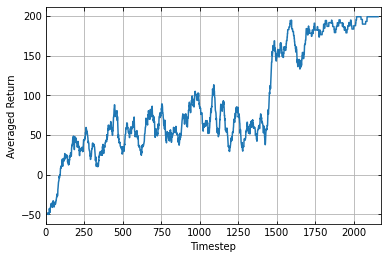

In [ ]:
## Visualization
t_lim       = len(return_list)
window_size = 30

# smooth return
v = np.ones(window_size)/window_size
smoothed_return = np.convolve( return_list, v, mode='valid')

# plot
xlim = np.array(range(window_size-1,t_lim)) - window_size/2
plt.plot(xlim, smoothed_return)
plt.xlabel('Timestep')
plt.ylabel('Averaged Return')
plt.tick_params(top = True, right = True, direction = 'in')
plt.grid(which='both')
plt.xlim(0,t_lim)
plt.show()

- テスト（学習した方策を実際に動かしてみる）

In [ ]:
n_movie = 2 # 3以上に設定しても、なぜか2エピソードしか保存されず..

# エピソードを生成し、動画を保存
envw = wrap_env(gym.make('CartPole-v0'))

for i in range(n_movie):

    obs   = envw.reset()
    done  = False
    ret   = 0

    while not done:
        envw.render()
        state  = obs_discretizer.get_state(obs)
        action = agent.policy(state)           # 行動選択
        obs, r, done, info = envw.step(action) # 行動を環境に入力して、次状態などを受け取る
        ret += r

    print('test episode:', i+1, 'total reward:', ret)

envw.close()

# 動画の再生
show_video()

# Colab上から動画を削除
#!rm video/openaigym.video.*

test episode: 1 total reward: 200.0
test episode: 2 total reward: 200.0
